<a href="https://colab.research.google.com/github/Ritam646/CodeAlpha_Credit-Scoring-Model/blob/main/CodeAlpha_Credit_Scoring_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!pip install librosa xgboost seaborn

In [39]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import joblib

In [43]:
df = pd.read_csv('/content/drive/MyDrive/CodeAlpha_Internship/credit_data.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [45]:
df.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,895
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,3116
loan_status,0
loan_percent_income,0


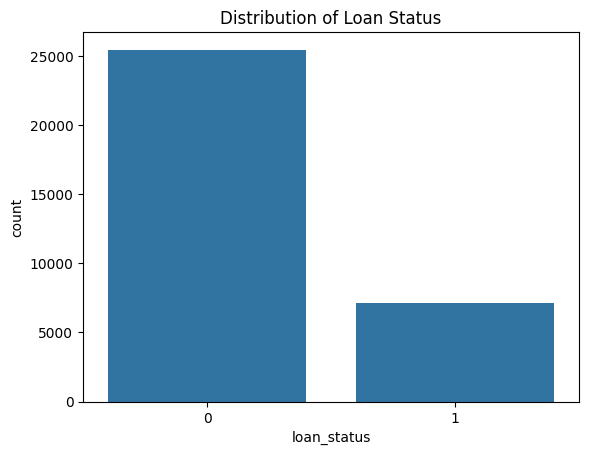

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='loan_status', data=df)
plt.title('Distribution of Loan Status')
plt.show()

In [47]:
df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)
df['loan_int_rate'].fillna(df['loan_int_rate'].median(), inplace=True)


/tmp/ipython-input-47-1382842016.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)
/tmp/ipython-input-47-1382842016.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].

In [48]:
df.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_status,0
loan_percent_income,0


In [49]:
df['person_emp_length'] = df['person_emp_length'].clip(upper=50)

In [50]:
le = LabelEncoder()
df['cb_person_default_on_file'] = le.fit_transform(df['cb_person_default_on_file'])
df = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'loan_grade'], drop_first=True)

In [51]:
df['debt_to_income'] = df['loan_amnt'] / df['person_income']


In [52]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']


In [53]:
scaler = StandardScaler()
numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate',
                  'loan_percent_income', 'cb_person_cred_hist_length', 'debt_to_income']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
df['loan_status'].value_counts()

,count
loan_status,
0,25473
1,7108


In [56]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [57]:
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


Precision: 0.957169459962756
Recall: 0.7114186851211073
F1-Score: 0.8161969035331481
ROC-AUC: 0.9357215951884557


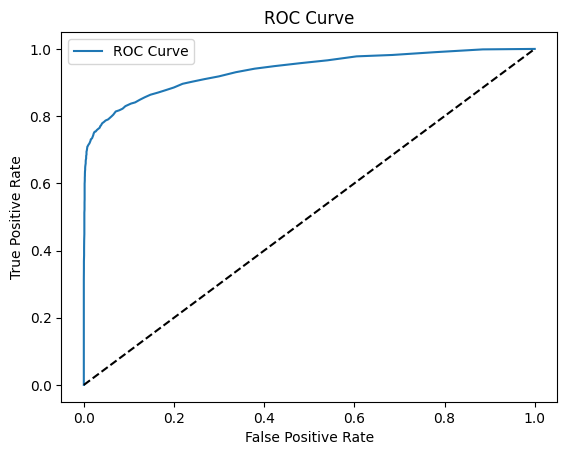

In [58]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

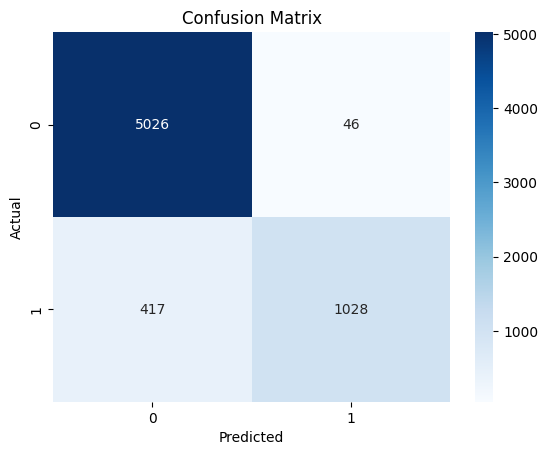

In [59]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [60]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]))
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Precision:", precision_score(y_test, y_pred_xgb))
print("XGBoost Recall:", recall_score(y_test, y_pred_xgb))
print("XGBoost F1-Score:", f1_score(y_test, y_pred_xgb))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:08:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Precision: 0.8180545836249126
XGBoost Recall: 0.8089965397923875
XGBoost F1-Score: 0.813500347947112
XGBoost ROC-AUC: 0.9500699955246528


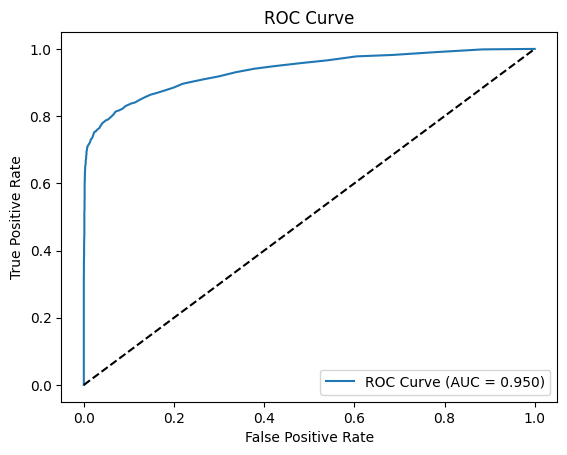

In [61]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {0.950:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('/content/drive/MyDrive/CodeAlpha_Internship/roc_curve_xgb.png')
plt.show()


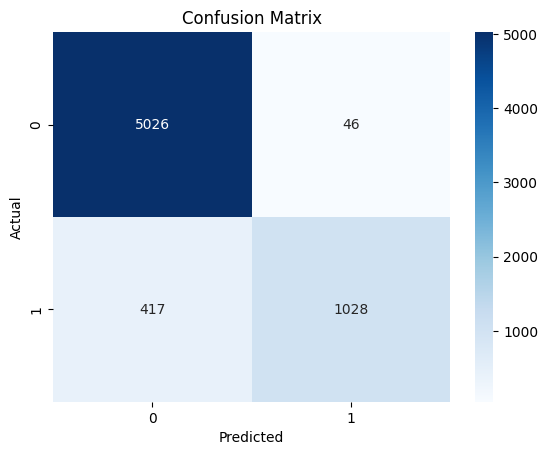

In [62]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('/content/drive/MyDrive/CodeAlpha_Internship/confusion_matrix_xgb.png')
plt.show()

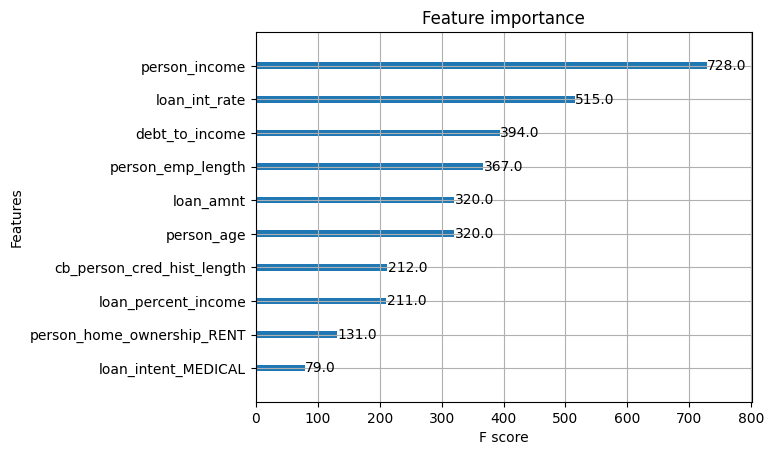

In [63]:
from xgboost import plot_importance
plot_importance(xgb_model, max_num_features=10)
plt.savefig('/content/drive/MyDrive/CodeAlpha_Internship/feature_importance_xgb.png')
plt.show()

In [64]:
joblib.dump(model, '/content/drive/MyDrive/CodeAlpha_Internship/credit_model.pkl')

['/content/drive/MyDrive/CodeAlpha_Internship/credit_model.pkl']